In [9]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

In [10]:
# =====================
# CONFIGURAÇÕES
# =====================
model_path = './models/xray_model.hdf5'
img_path = './images/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg'
class_names = ['NORMAL', 'PNEUMONIA']

In [11]:
# =====================
# FUNÇÕES AUXILIARES
# =====================
def preprocess_image(img_path, target_size=(180, 180)):
    img = Image.open(img_path).convert("RGB")
    img = ImageOps.fit(img, target_size, method=Image.Resampling.LANCZOS)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

In [12]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layer found.")

In [13]:
# =====================
# SALIENCY MAP
# =====================
def make_saliency_map(img_array, model, pred_index=None):
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        output = preds[:, pred_index]

    grads = tape.gradient(output, img_tensor)[0]
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)
    return saliency.numpy()

<KerasTensor shape=(None, 2), dtype=float32, sparse=False, ragged=False, name=keras_tensor_109>


2025-05-27 18:29:48.827827: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25660800 exceeds 10% of free system memory.
2025-05-27 18:29:48.832689: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27993600 exceeds 10% of free system memory.


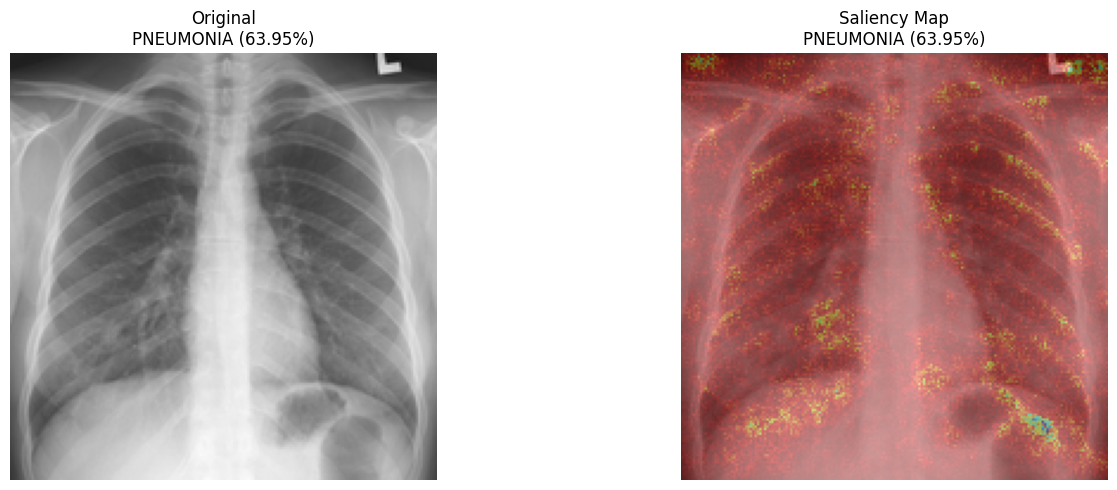

In [14]:
# =====================
# EXECUÇÃO
# =====================
model = load_model(model_path, compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

img_array, raw_img = preprocess_image(img_path)
preds = model.predict(img_array, verbose=0)
print(model.get_layer('dense_3').output)
score = tf.nn.softmax(preds[0])
class_names = ['NORMAL', 'PNEUMONIA']

pred_index = tf.argmax(preds[0]).numpy()
pred_class = class_names[pred_index]
confidence = tf.nn.softmax(preds[0])[pred_index].numpy()

saliency = make_saliency_map(img_array, model, pred_index)

plt.figure(figsize=(15, 5))
heatmap_resized = cv2.resize(saliency, (raw_img.size[0], raw_img.size[1]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.array(raw_img), 0.6, heatmap_color, 0.4, 0)

titles = ['Original', 'Saliency Map']

plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeira posição
plt.imshow(raw_img)
plt.title(f"{titles[0]}\n{pred_class} ({confidence*100:.2f}%)")
plt.axis("off")

plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segunda posição
plt.imshow(superimposed_img)
plt.title(f"{titles[1]}\n{pred_class} ({confidence*100:.2f}%)")
plt.axis("off")

plt.tight_layout()
plt.show()